## Regression Tree
### Version 1.5 - take-aways from class
In this problem we want to implement Decision Trees for regression from scratch without using the sklearn library. Implement the generation of a full tree of given depth. As a guide you might have a look at the book The Elements of Statistical Learning by Hastie et al. (you can find the relevant section on p. 305-308 in Moodle in the file Decision Trees.pdf ). For this exercise you do not need to implement tree pruning. Check your implementation with the functions proposed in the jupyter notebook functions.ipynb in Moodle (two functions are 1D, one function is 2D). Plot approximations for different depths and consider train/test errors depending on different tree depths. Make your implementation as efficient as possible to save time, e.g. by avoiding unnecessary computations and using a suitable storage structure. Optional: implement a criterion such that nodes are created iff the cost decrease is sufficient.

**Disclaimer:** This project was written with the assistance of GitHub Copilot (GPT 4o)

In [1]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
### Settings
np.random.seed(42)
pd.set_option('display.float_format', '{:.3f}'.format)

## Generate artificial data
### Functions

In [3]:
def f(x, sigma):     # first test function
    return x**2+ np.random.normal(0, sigma, len(x))

In [4]:
def g(x,sigma):     # second test function
    z=np.random.normal(0, sigma, len(x))
    return 2*((x>=0)*(x<=0.25)+(x>=0.5)*(x<=0.75))-1 + z

In [5]:
def h(x1,x2,sigma): # third test function
    z=np.random.normal(0, sigma, len(x1))
    p1 = (0<=x1)*(x1<=1/3)*(0<=x2)*(x2<=1/3)
    p2 = (0<=x1)*(x1<=1/3)*(2/3<=x2)*(x2<=1)
    p3 = (1/3<=x1)*(x1<=2/3)*(1/3<=x2)*(x2<=2/3)
    p4 = (2/3<=x1)*(x1<=1)*(0<=x2)*(x2<=1/3)
    p5 = (2/3<=x1)*(x1<=1)*(2/3<=x2)*(x2<=1)
    return p1+p2+p3+p4+p5+z

### Plotting

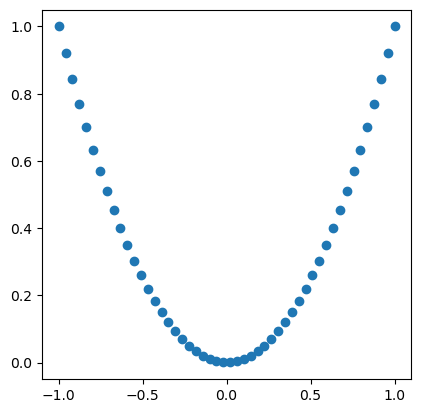

In [6]:
# Plot of first test function
x = np.linspace(-1, 1, 50)
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(x,f(x,0))
ax.set_box_aspect(1)

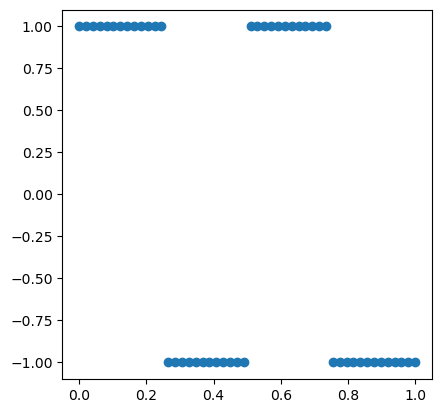

In [7]:
# Plot of second test function
x = np.linspace(0,1,50)
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(x,g(x,0))
ax.set_box_aspect(1)

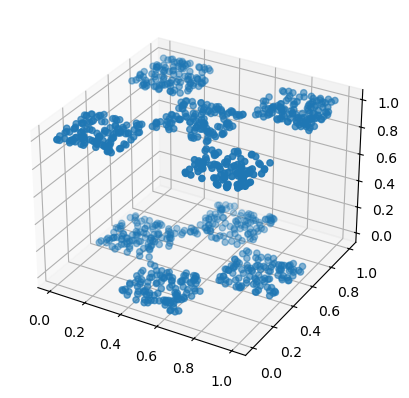

In [8]:
# plot of third test function
x1 = np.random.uniform(0,1,1000)
x2 = np.random.uniform(0,1,1000)
y = h(x1,x2,0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y);

## Requirements:
- Parameters:
    - multidimensional data - we need to be able to deal with data consisting of multiple features 
    - targets (regression) - we want a regression algorythm
    - new data (prediction) - we want to be able to predict new data 
    - tree depth - we want to handle model complexity by limiting the tree depth (number of sequential decisions)
- Node splitting:
    - training samples will be split into two groups (left and right child) at each node
    - the split is based on a single feature (for multidimensional data) only
    - choose splitting point out of all possible splits based on the best weighted mean squared error (MSE)
    - choose feature for splitting based on the best weighted MSE as well
- Hints
    - implement the tree as class to ensure efficient data management
    - use recursive node-splitting

## Approach
1. One-dimensional stump
2. Two-dimensional stump
3. Class 
## One-dimensional stump

### Data

In [9]:
### Generate one-dimensional data
X = np.linspace(0, 1, 50) # 50_000 points
np.random.shuffle(X)
y = f(X, 0)

In [10]:
print(type(X), type(y))
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50,) (50,)


### No train-test-split

In [11]:
X_train, y_train = X, y
print('X_train:', X_train.shape)
print('y_train:', y_train.shape, y_train.mean())


X_train: (50,)
y_train: (50,) 0.336734693877551


### Brute force implementation
Calculate the MSE for every possible split

In [12]:
criterions = []

### Loop through all training data points as split points
for split_point in X_train:
    
    ### Split the data
    left_ys = y_train[X_train < split_point]
    right_ys = y_train[X_train >= split_point]

    ### Calculate the weighted MSE
    criterion = np.sum((left_ys - left_ys.mean())**2) + np.sum((right_ys - right_ys.mean())**2)
    criterions.append(criterion)


### Find the best split point
best_split_point = X_train[np.argmin(criterions)]

### Calculate the values for predictions
left_pred = y_train[X_train < best_split_point].mean()
right_pred = y_train[X_train >= best_split_point].mean()

### Predict training data
# y_pred_train = np.zeros(y_train.shape)
y_pred_train = np.where(X_train < best_split_point, left_pred, right_pred)

/tmp/ipykernel_7959/1622445321.py:11: RuntimeWarning: Mean of empty slice.
  criterion = np.sum((left_ys - left_ys.mean())**2) + np.sum((right_ys - right_ys.mean())**2)
/home/oskar/anaconda3/envs/kfu/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


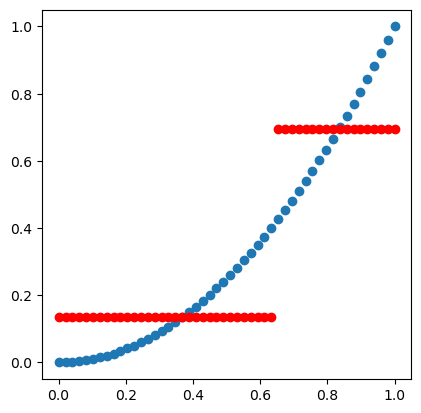

In [13]:
# Plot of first test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred_train, color='red')
ax.set_box_aspect(1)

### Cumulative sums implementation

**Idea:**



$$
\text{MSE}_{\text{left}} = \sum (y_{\text{left}} - \bar{y}_{\text{left}})^2
$$

Expanding the squared term:

$$
\text{MSE}_{\text{left}} = \sum y_{\text{left}}^2 - 2 \bar{y}_{\text{left}} \sum y_{\text{left}} + \text{count}_{\text{left}} \cdot \bar{y}_{\text{left}}^2
$$

Substitute $( \bar{y}_{\text{left}} = \frac{\text{sum}_{\text{left}}}{\text{count}_{\text{left}}} )$:

$$
\text{MSE}_{\text{left}} = \sum y_{\text{left}}^2 - \frac{(\text{sum}_{\text{left}})^2}{\text{count}_{\text{left}}}
$$


**Conclusion:**

- $\text{criterion} = \text{MSE}_{\text{right}} + \text{MSE}_{\text{right}}$
- $\text{MSE}_{\text{right}}$ can be calculated in analogy
- Both formulas are give the same result.
- Cumulative approach
    - is less intuitive
    - has a much leaner for loop

In [14]:
### Ensure X_train and y_train are numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

### Sort the data
sorted_indices = np.argsort(X_train)
X_train_sorted = X_train[sorted_indices]
y_train_sorted = y_train[sorted_indices]

### Compute cumulative sums
cumsum_y = np.cumsum(y_train_sorted)            # cumulative sum of target values
cumsum_y_sq = np.cumsum(y_train_sorted**2)      # cumulative sum of squared target values

### Total sum and sum of squares
total_sum_y = cumsum_y[-1]
total_sum_y_sq = cumsum_y_sq[-1]

### Number of samples
n = len(y_train_sorted)

### Initialize array to store MSE values
mse_values = np.zeros(n-1)

### Calculate MSE for each split point
for i in range(1, n):
    left_count = i
    right_count = n - i
    
    left_sum_y = cumsum_y[i-1]
    right_sum_y = total_sum_y - left_sum_y
    
    left_sum_y_sq = cumsum_y_sq[i-1]
    right_sum_y_sq = total_sum_y_sq - left_sum_y_sq
    
    left_mse = left_sum_y_sq - (left_sum_y**2) / left_count
    right_mse = right_sum_y_sq - (right_sum_y**2) / right_count
    
    mse_values[i-1] = left_mse + right_mse

### Find the best split point
best_split_index = np.argmin(mse_values)
best_split_point = X_train_sorted[best_split_index]

### Calculate the values for predictions
pred_left = y_train_sorted[:best_split_index+1].mean()
pred_right = y_train_sorted[best_split_index+1:].mean()

### Predict training data
y_pred_train_sq = np.where(X_train < best_split_point, pred_left, pred_right)

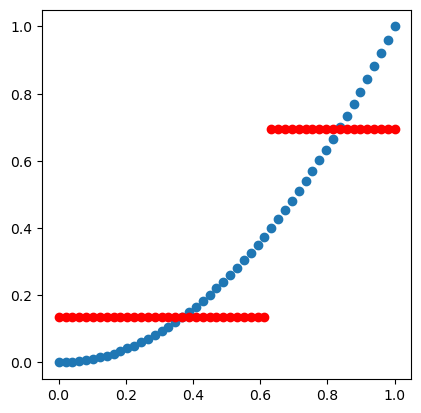

In [15]:
# Plot of first test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred_train_sq, color='red')
ax.set_box_aspect(1)

In [16]:
np.array_equal(y_pred_train_sq, y_pred_train)

False

In [17]:
compare_df = pd.DataFrame({'true': y_train, 'brute': y_pred_train, 'cumsum': y_pred_train_sq})
compare_df['match'] = compare_df['brute'] == compare_df['cumsum']
compare_df.loc[compare_df['match'] == False]

,true,brute,cumsum,match
36,0.400,0.136,0.694,False


However, it is much faster:
- `n = 50_000`
- brute force: `11.1 sec`
- cumsum:  `0.2 sec` (!!!)
- results are not identical, center value is missclassified

### Cumulative sums as function

In [18]:
def split_feature(x_train, y_train):
    '''
    Split a feature vector (1D) into two parts with minimal MSE.

    Parameters:
        x_train (np.array): 1D array of feature values
        y_train (np.array): 1D array of target values

    Returns:
        criterion: The MSE of the best split
        left_idx: The indices of the left data
        right_idx: The indices of the right data
    '''
    ### Sort the target by feature values
    sorted_indices = np.argsort(x_train)
    y_train_sorted = y_train[sorted_indices]

    ### Compute cumulative sums
    cumsum_y = np.cumsum(y_train_sorted)            # cumulative sum of target values
    cumsum_y_sq = np.cumsum(y_train_sorted**2)      # cumulative sum of squared target values

    ### Total sum and sum of squares
    total_sum_y = cumsum_y[-1]
    total_sum_y_sq = cumsum_y_sq[-1]

    ### Number of samples
    n = len(y_train_sorted)

    ### Initialize array to store MSE values
    mse_values = np.zeros(n-1)

    ### Calculate MSE for each split point
    for i in range(1, n):
        left_count = i
        right_count = n - i
        
        left_sum_y = cumsum_y[i-1]
        right_sum_y = total_sum_y - left_sum_y
        
        left_sum_y_sq = cumsum_y_sq[i-1]
        right_sum_y_sq = total_sum_y_sq - left_sum_y_sq
        
        left_mse = left_sum_y_sq - (left_sum_y**2) / left_count
        right_mse = right_sum_y_sq - (right_sum_y**2) / right_count
        
        mse_values[i-1] = left_mse + right_mse

    ### Find the best split point
    best_split_index = np.argmin(mse_values)

    ### Return the MSE of the best split point and the indices of the left and right data
    return np.min(mse_values), sorted_indices[:best_split_index+1], sorted_indices[best_split_index+1:]

criterion, left_idx, right_idx = split_feature(X_train, y_train)

### Predict training data
y_pred_train_func = np.full(y_train.shape, y_train[left_idx].mean())
y_pred_train_func[right_idx] = y_train[right_idx].mean()

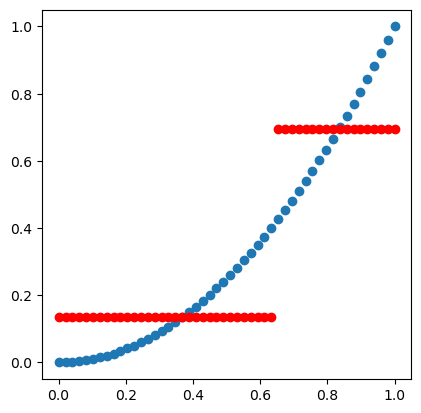

In [19]:
# Plot of first test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred_train_func, color='red')
ax.set_box_aspect(1)

## Two-dimensional stump
### Data

In [20]:
### Seeding
np.random.seed(0)

### Features
x0 = np.random.uniform(0,1,1000)
x1 = np.random.uniform(0,1,1000)

### Target
y = h(x0,x1,0)

In [21]:
print(type(x0))
print(type(x1))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [22]:
print(x0.shape)
print(x1.shape)
print(y.shape)

(1000,)
(1000,)
(1000,)


### Implementation

In [23]:
splits_df = pd.DataFrame([split_feature(x, y) for x in [x0, x1]], 
                          columns=['MSE', 'left_idx', 'right_idx'])
splits_df

,MSE,left_idx,right_idx
0,236.476,"[821, 757, 540, 742, 99, 852, 524, 309, 166, 4...","[750, 127, 323, 978, 786, 594, 467, 347, 500, ..."
1,239.554,"[633, 70, 130, 712, 234, 974, 62, 946, 747, 92...","[349, 561, 359, 74, 844, 258, 344, 667, 695, 1..."


In [24]:
### Subset for the feature with the smallest MSE
split_f_idx = splits_df['MSE'].idxmin()
print('split_f_idx:', split_f_idx, type(split_f_idx))

### Get the indices of the left and right data
left_idx = splits_df.loc[split_f_idx, 'left_idx']
right_idx = splits_df.loc[split_f_idx, 'right_idx']

print('left_idx:', type(left_idx))
print('right_idx:', type(left_idx))


split_f_idx: 0 <class 'int'>
left_idx: <class 'numpy.ndarray'>
right_idx: <class 'numpy.ndarray'>


In [25]:
### Predict training data
y_pred = np.full(y.shape, y[left_idx].mean())
y_pred[right_idx] = y[right_idx].mean()

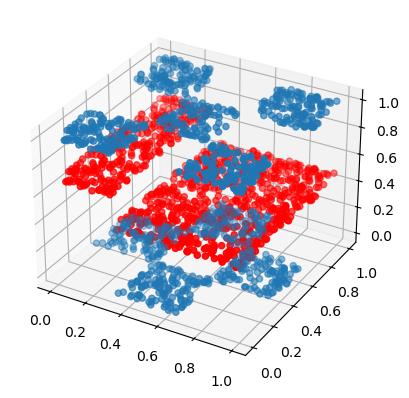

array([0.46965318, 0.70454545])

In [26]:
# plot of third test function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x0,x1,y)
ax.scatter(x0,x1,y_pred, color='red')
plt.show()
pd.Series(y_pred).unique()

## Classes

In [27]:
from utils.tree import Node, RegressionTree

### Testing
#### Node class

In [28]:
### Example: Creating a root node
root = Node(feature_idx=0, x_threshold=1.5, left_child=None, right_child=None, node_value=None)

root.feature_idx = 1
root.left_child = root

print(root.feature_idx)
print(root.x_threshold)
print(root.left_child)
print(root.node_value)

1
1.5
None


#### Helper functions

In [29]:
### Seeding
np.random.seed(0)

### Features
x0 = np.random.uniform(0,1,1000)
x1 = np.random.uniform(0,1,1000)
# np.random.shuffle(x0)             # shuffling the data causes error during prediction
# np.random.shuffle(x1)             # shuffling the data causes error during prediction
X = np.column_stack((x0, x1))

### Target
y = h(x0,x1,0)

print(type(X), X.shape)
print(type(y), y.shape)

<class 'numpy.ndarray'> (1000, 2)
<class 'numpy.ndarray'> (1000,)


In [30]:
tree = RegressionTree(max_depth=None, min_samples_split=2)

tree._find_best_split(X, y)

(0,
 0.3000289194759296,
 array([821, 757, 540, 742,  99, 852, 524, 309, 166, 417, 990, 283, 410,
        398, 262, 545, 173,  34, 697, 126,  97,  16, 214, 530, 204, 233,
        722, 691, 682, 522, 179, 409, 394, 351, 571, 927,  75, 586, 800,
        931, 343, 443, 740, 507, 837, 307, 171, 322, 332, 911, 198, 457,
        655, 903, 587,  43, 588, 630, 390, 603, 823, 268,  82, 427, 708,
        707, 205, 412, 942, 159, 968, 673, 480,  14, 787, 583, 345, 312,
        702, 303, 745, 255, 703,  15, 528, 313, 555,  87,  69, 913, 614,
         67, 551, 649, 995, 296, 402, 933, 705, 146, 261,  53, 784, 689,
        510, 453, 637, 842, 789, 684,  61, 678, 962, 814, 418, 831, 535,
        657, 909, 662, 636, 738, 793, 241,  24,  79, 906,  77, 154, 357,
         47, 416, 484, 321,  92, 243, 306, 613, 561, 132, 291,  63, 780,
        858, 940, 888,  26, 248, 311, 629, 866, 645, 285, 150, 937, 482,
        714, 785,  60, 829, 387, 739, 580, 576, 375,  55, 710, 952, 152,
        423, 180, 773, 653

#### Fit / tree construction

In [31]:
pd.Series(y).value_counts()

1.000    542
0.000    458
Name: count, dtype: int64

In [32]:
tree = RegressionTree(max_depth=10, min_samples_split=2)
tree.fit(X, y)
tree.root.left_child.right_child.node_value

1.0

In [33]:
tree = RegressionTree(max_depth=2, min_samples_split=2)
tree.fit(X, y)

try:
    result = tree.root.left_child.right_child.node_value           # This should raise an error 
except Exception as e:
    # Handle the error
    print(f"Error: {e}")
    result = None  

Error: 'NoneType' object has no attribute 'node_value'


#### Prediction

In [34]:
tree = RegressionTree(max_depth=10, min_samples_split=2)
tree.fit(X, y)
y_pred = tree.predict(X)

print(y_pred.shape)
print(y_pred[:10])

(1000,)
[1. 1. 1. 0. 0. 0. 1. 1. 1. 0.]


## Performance

In [35]:
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

### h(x), n = `10_000`, depth = `10`

In [36]:
### Data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2)

print(type(X_train), type(y_train))
print(type(X_test), type(y_test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(np.unique(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(800, 2) (800,)
(200, 2) (200,)
[0. 1.]


In [37]:
tree = RegressionTree(max_depth=10, min_samples_split=2)
tree.fit(X_train, y_train)

print('train error:', MSE(y_train, tree.predict(X_train)))
print('test error:', MSE(y_test, tree.predict(X_test)))

train error: 0.01125
test error: 0.015


### h(x), n = `10_000`

In [38]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4, 5, 10, None]
for depth in depths:
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (MSE(y_train, tree.predict(X_train)), 
                      MSE(y_test, tree.predict(X_test)),
                      pd.Series(tree.predict(X_train)).unique())
    models[depth] = tree

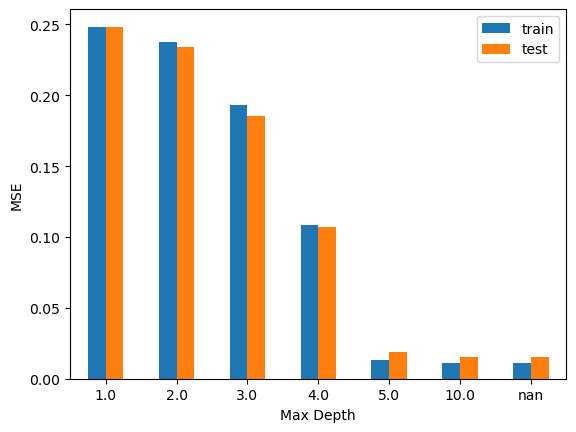

,train,test,values
1.000,0.248,0.248,[0.5425]
2.000,0.238,0.234,"[0.4712430426716141, 0.6896551724137931]"
3.000,0.193,0.185,"[0.6802973977695167, 0.5207100591715976, 0.262..."
4.000,0.109,0.107,"[0.48502994011976047, 0.0, 0.42771084337349397..."
5.000,0.013,0.019,"[0.0, 0.9594594594594594, 1.0]"
10.000,0.011,0.015,"[0.0, 1.0]"
NaN,0.011,0.015,"[0.0, 1.0]"


In [39]:
df = pd.DataFrame(results, index=['train', 'test', 'values']).T
df[['train', 'test',]].plot(kind='bar')
plt.ylabel('MSE')
plt.xlabel('Max Depth')
plt.xticks(rotation=0)
plt.show()
df

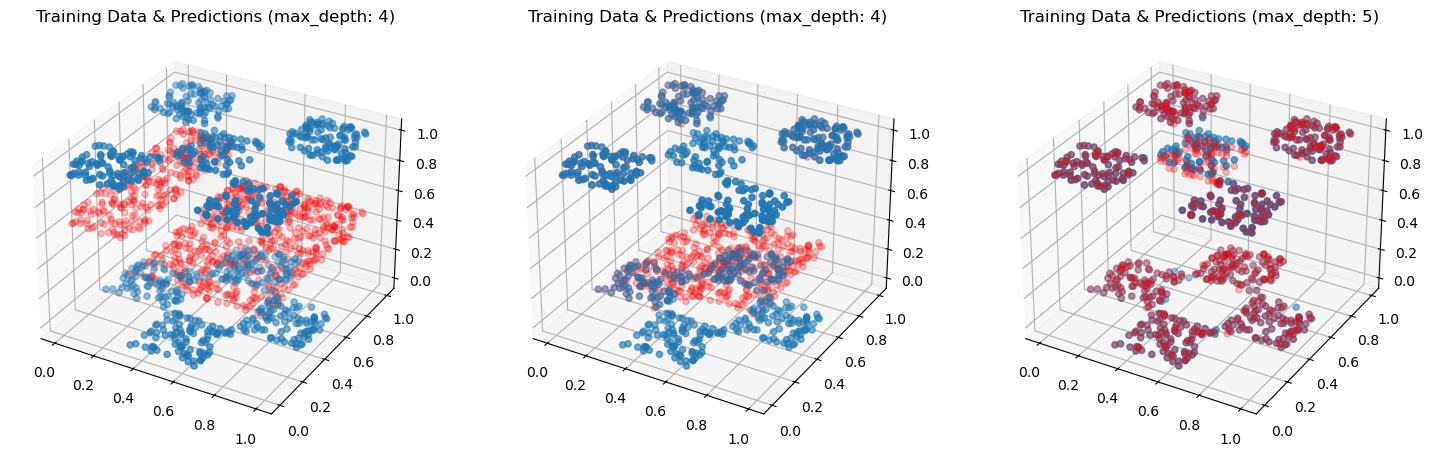

max_depth: 4 values


In [40]:
### Chose models to plot
left_depth = 2
middle_depth = 4
right_depth = 5
alpha = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# First plot
axs[0].scatter(X_train[:,0], X_train[:,1], y_train)
axs[0].scatter(X_train[:,0], X_train[:,1], models[left_depth].predict(X_train), color='red', alpha=alpha)
axs[0].set_title(f'Training Data & Predictions (max_depth: {middle_depth})')

# Second plot
axs[1].scatter(X_train[:,0], X_train[:,1], y_train)
axs[1].scatter(X_train[:,0], X_train[:,1], models[middle_depth].predict(X_train), color='red', alpha=alpha)
axs[1].set_title(f'Training Data & Predictions (max_depth: {middle_depth})')

# Third plot
axs[2].scatter(X_train[:,0], X_train[:,1], y_train)
axs[2].scatter(X_train[:,0], X_train[:,1], models[right_depth].predict(X_train), color='red', alpha=alpha)
axs[2].set_title(f'Training Data & Predictions (max_depth: {right_depth})')

plt.show()

print(f'max_depth: {middle_depth} values')

### f(x), `n = 50`

In [41]:
### Data
np.random.seed(0)
X = np.linspace(-1, 1, 50)
y = f(X,0)

### Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Reshape data
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print(type(X_train), type(y_train))
print(type(X_test), type(y_test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(40, 1) (40,)
(10, 1) (10,)


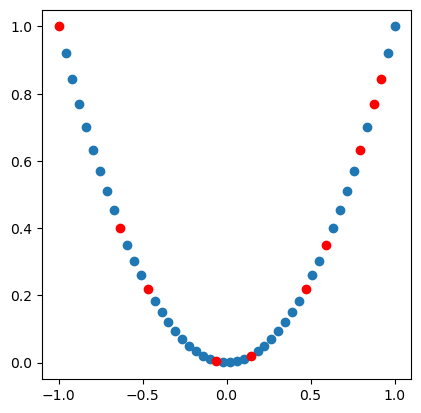

In [42]:
### Plot of first test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color='red')
ax.set_box_aspect(1)

In [43]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4]
for depth in depths:
    print(f'depth: {depth}')
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (MSE(y_train, tree.predict(X_train)), 
                      MSE(y_test, tree.predict(X_test)),
                      pd.Series(tree.predict(X_train)).nunique())
    models[depth] = tree

depth: 1
depth: 2
depth: 3
depth: 4


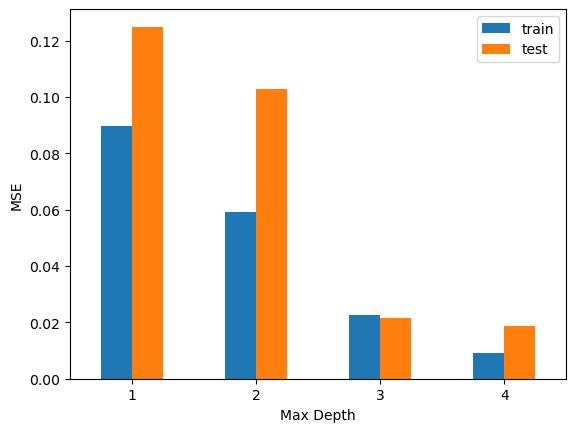

,train,test,n_values
1,0.090,0.125,1.000
2,0.059,0.103,2.000
3,0.023,0.021,4.000
4,0.009,0.019,7.000


In [44]:
df = pd.DataFrame(results, index=['train', 'test', 'n_values']).T
df[['train', 'test',]].plot(kind='bar')
plt.ylabel('MSE')
plt.xlabel('Max Depth')
plt.xticks(rotation=0)
plt.show()
df

In [45]:
tree = RegressionTree(max_depth=5, min_samples_split=2)
tree.fit(X_train, y_train)
try:
    result = tree.predict(X_test)
except Exception as e:
    # Handle the error
    print(f"Error: {e}")
    result = None  

Error: 'NoneType' object has no attribute 'left_child'


### g(x), `n = XX`

In [46]:
### Data
np.random.seed(0)
X = np.linspace(0, 1, 50)
y = g(X,0)

### Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

### Reshape data
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

print(type(X_train), type(y_train))
print(type(X_test), type(y_test))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(np.unique(y_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(40, 1) (40,)
(10, 1) (10,)
[-1.  1.]


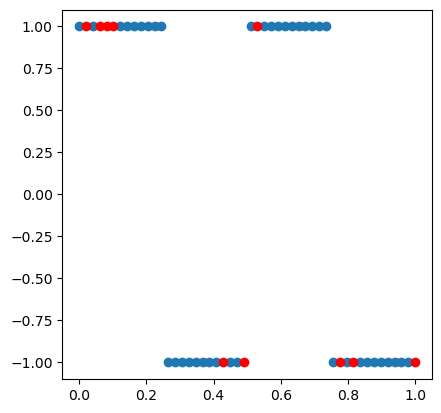

In [47]:
# Plot of second test function
fig = plt.figure()
ax = fig.add_subplot()
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color='red')
ax.set_box_aspect(1)

In [48]:
### Containers
results = {}
models = {}

### Loop through different depths
depths = [1, 2, 3, 4, 10, None]
for depth in depths:
    print(f'depth: {depth}')
    tree = RegressionTree(max_depth=depth, min_samples_split=2)
    tree.fit(X_train, y_train)
    results[depth] = (MSE(y_train, tree.predict(X_train)), 
                      MSE(y_test, tree.predict(X_test)),
                      pd.Series(tree.predict(X_train)).unique())
    models[depth] = tree

depth: 1
depth: 2
depth: 3
depth: 4
depth: 10
depth: None


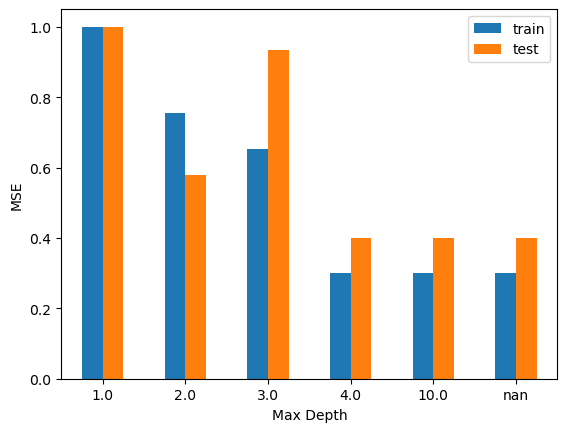

,train,test,values
1.000,1.000,1.000,[0.0]
2.000,0.756,0.578,"[0.3333333333333333, -1.0]"
3.000,0.651,0.933,"[-0.05263157894736842, -1.0, 1.0]"
4.000,0.300,0.400,"[-1.0, 1.0]"
10.000,0.300,0.400,"[-1.0, 1.0]"
NaN,0.300,0.400,"[-1.0, 1.0]"


In [49]:
df = pd.DataFrame(results, index=['train', 'test', 'values']).T
df[['train', 'test',]].plot(kind='bar')
plt.ylabel('MSE')
plt.xlabel('Max Depth')
plt.xticks(rotation=0)
plt.show()
df

### Checking for features dimensionality

In [50]:
from sklearn.datasets import make_regression

dimensions = [1, 2, 3, 4, 5, 10, 100, 1000]

for dim in dimensions:
    print(f'Dimension: {dim}')
    X, y = make_regression(n_samples=100, n_features=dim, noise=0.1)
    tree = RegressionTree(max_depth=10, min_samples_split=2)
    try:
        result = tree.fit(X, y) 
    except Exception as e:
        # Handle the error
        print(f"Error: {e}")
        result = None   

Dimension: 1
Dimension: 2


Dimension: 3
Dimension: 4
Dimension: 5
Dimension: 10
Dimension: 100
Dimension: 1000


### Checking for features sorting

In [51]:
X, y = make_regression(n_samples=10, n_features=1, noise=0.15)
tree = RegressionTree(max_depth=10, min_samples_split=2)
tree.fit(X, y)

In [52]:
X

array([[-1.25852862],
       [-0.49995179],
       [ 2.16874191],
       [-0.67499551],
       [-0.33686143],
       [-0.09741961],
       [ 0.72677122],
       [ 0.17278207],
       [ 0.68260776],
       [ 0.84469566]])

**Conclusion:** reshape 1-dimensional features (!!!)

## Future work
- suspecting indexing error when splitting
- shuffling the features for h(x) and depth > 5 for f(x) cause leaf misassignment 

# The End